**ST3233 Project Group Number**

Gerry Lim Wee Kiat A0189186L

Wong Hui Hui A0184497L

Kimberly Chan Yuan Lin A0187892H

Josiah Loke Wai Kit A0187635R

# Importing of Libraries

In [1]:
import numpy as np
import pandas as pd
import statsmodels
import math 
#!pip3 install --user statsmodels --upgrade 
#Need to run statsmodels on latest version
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import tsaplots
from statsmodels.tsa.holtwinters import Holt
%matplotlib inline
import pylab as plt
from sklearn.metrics import mean_squared_error

# 1. Introduction


This project aims to explore different models for time series forecasting on a business. We focused on the total turnover from all the industries in Australia. 

# 2. Dataset

We downloaded monthly Australian retail data from a book website. These represent retail sales in various categories for different Australian states. We only selected one of the timeseries and analysed it.

# 3. Goal of Analysis
We aim to compare different models for forecasting this time series using RMSE for comparison, to determine which is the best forecasting method for this dataset. 

We tried additive and multiplicative series with several models:


*   Moving Averages
*   SES / DES / TES
*   Linear Regression





# 4. Data Preprocessing

In [2]:
df = pd.read_excel("retail.xlsx")

In [3]:
dataset = df[["Unnamed: 0", 'Turnover ;  Total (State) ;  Total (Industry) ;']].drop(df.index[0:10]).rename(columns = {"Unnamed: 0": "Date", 'Turnover ;  Total (State) ;  Total (Industry) ;':"Turnover"}) #Dropped first 10 rows so series would start in January


In [4]:
dataset = dataset.reset_index(drop=True)
dataset.head()

,Date,Turnover
0,1983-01-01 00:00:00,3384.5
1,1983-02-01 00:00:00,3369.8
2,1983-03-01 00:00:00,3805.3
3,1983-04-01 00:00:00,3665.1
4,1983-05-01 00:00:00,3760


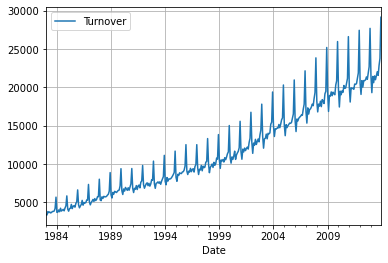

In [5]:
dataset.plot.line(x="Date", y="Turnover")
plt.grid(True)

## Split to train and test set

In [6]:
n_tot = len(dataset)
n_test = int(n_tot * 0.3)     #30% of data is the test set
n_train = n_tot - n_test
n_tot,n_test,n_train

(372, 111, 261)

In [7]:
train = dataset[:n_train]
test = dataset[n_train:]

# STL Decomposition 

In this section, we want to determine if the time series should be treated as an additive model or a multiplicative model. We first treat the time series as an **additive** model, and perform decomposition to better understand it. 

In [8]:
decomp = STL(train.Turnover, period=12, robust=True).fit()

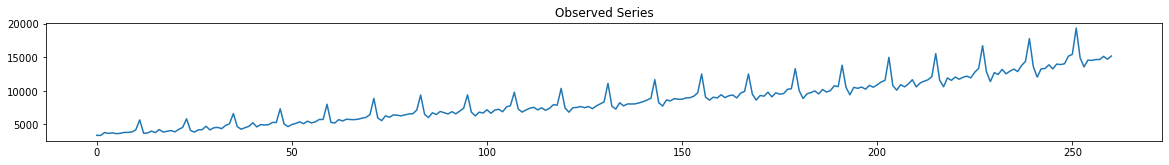

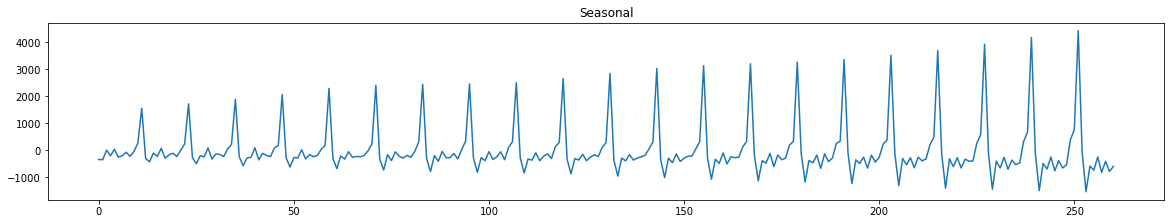

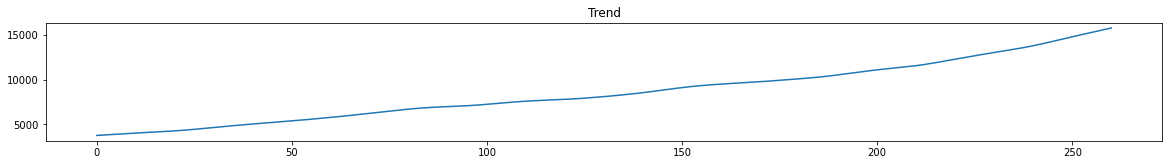

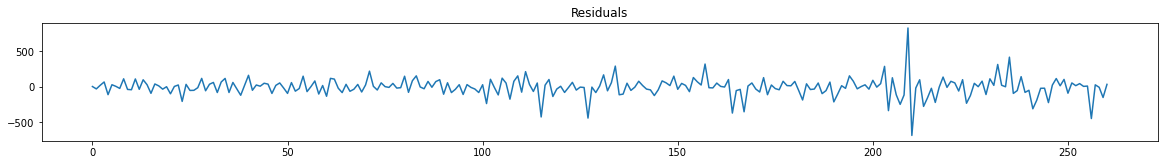

In [9]:
#Plotting the observed series
plt.figure(figsize=(20,10))
plt.subplot(4,1,1)
plt.title("Observed Series")
train.Turnover.plot()
plt.show()  

#Now we plot separately
S,T,E = decomp.seasonal, decomp.trend, decomp.resid
plt.figure(figsize=(20,15))
plt.subplot(4,1,2)
plt.title("Seasonal")
S.plot()
plt.show()       

plt.figure(figsize=(20,10))
plt.subplot(4,1,3)
plt.title("Trend")
T.plot()
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(4,1,4)
plt.title("Residuals")
E.plot()
plt.show()

For the seasonal part, we can see that the peaks of the graph are increasing, indicating that a multiplicative model might be better. There is also a constant interval where the turnover exhibits a similar pattern and spike.
We thus plot a lag plot for different lags to determine the lag for the series. 

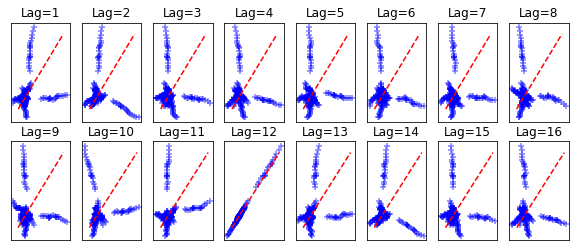

In [10]:
plt.figure(figsize=(10,4))
T_max = len(train) 
for lag in np.arange(1,17):
    plt.subplot(2,8,lag)      
    plt.scatter(S[:(T_max)-lag], S[lag:(T_max)], color="blue", marker="+", alpha=0.5)
    plt.plot([-1000,4000], [-1000,4000], "r--")  #add a red diagonal
    plt.title(f"Lag={lag}")
    plt.xticks([]) 
    plt.yticks([]) 
          

We see that from the correlation plots, lag = 12 has a very high correlation. This makes sure that our period when decomposing the original series would be with a period of 12. 

For the residuals, there is a huge spike in peaks around index 220. We plot a histogram of the residuals to see its distribution.

Mean of residuals is -10.114173884567652


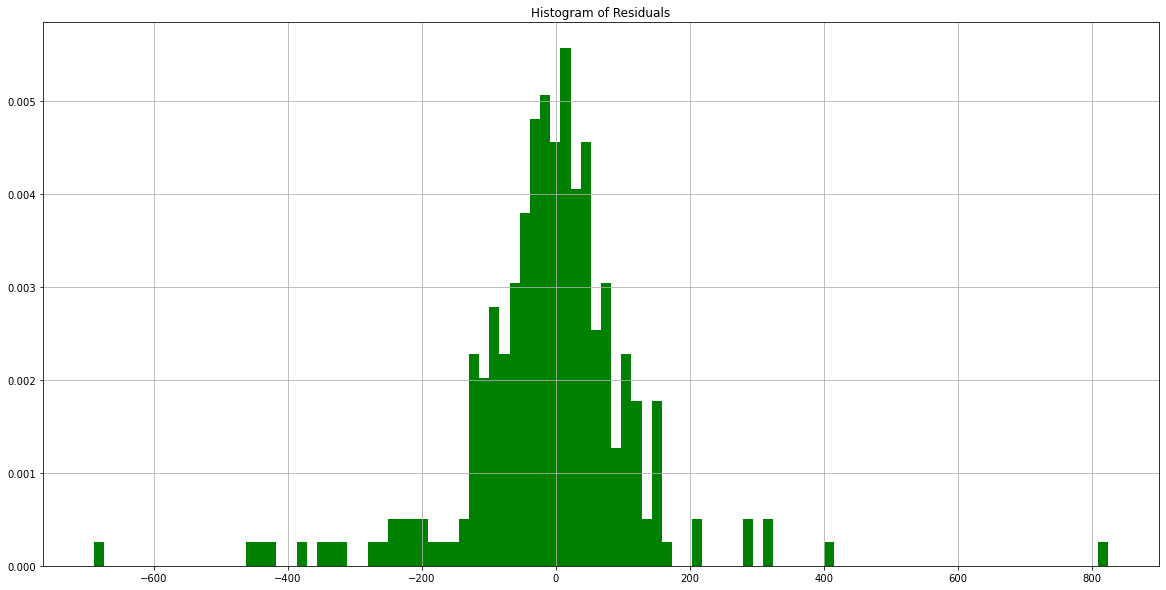

In [11]:
plt.figure(figsize=(20,10))
_ = plt.hist(E, bins=100, density=True, color="green")
plt.grid(True)
plt.title("Histogram of Residuals")  

print("Mean of residuals is",np.mean(E))

Plotting  residuals seem to follow a normal distribution with mean -10, although it is skewed towards the right. An autocorrelation plot of the residuals would give us a better idea if there is any correlation in the residuals.

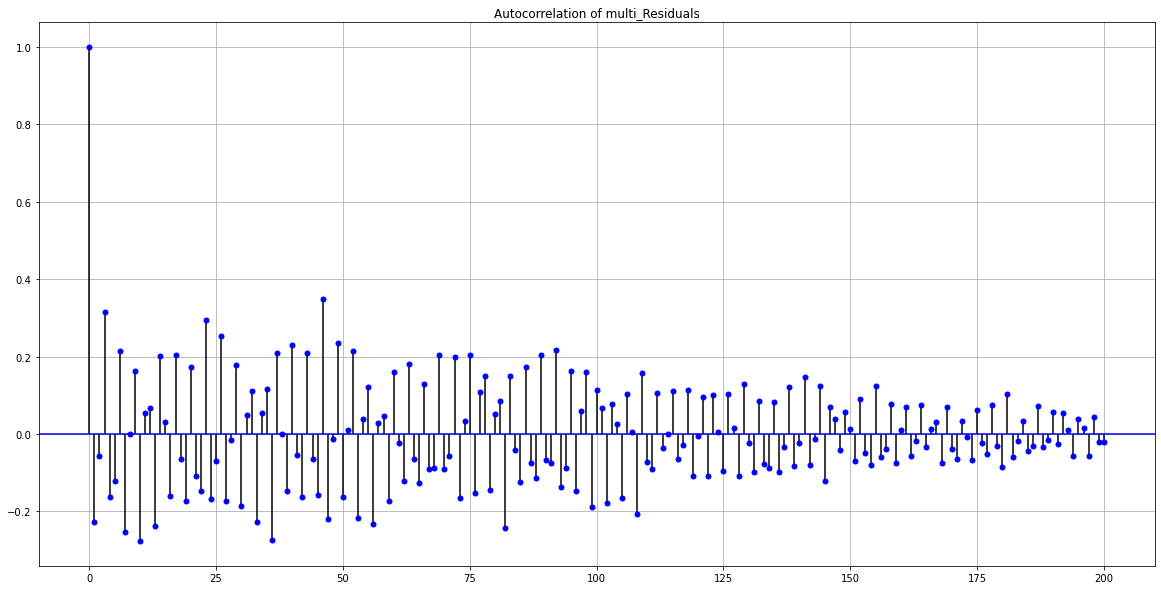

In [12]:
fig,ax = plt.subplots(figsize=(20,10)) 
fig = tsaplots.plot_acf(E, lags=200, alpha=None, title="Autocorrelation of multi_Residuals", color="blue",ax=ax)
plt.grid(True)

The autocorrelation plot shows that there is no significant correlation in the residual series. We can conclude that forecasts using an additive model would be good. 

We now assume the model is **multiplicative**, and plot the same plots as above. 
We need to take the log of the series since the STL function will assume that the series is additive. This is so that the decomposition would give us results of a multiplicative model. We follow the model: 
> $y_t=S_t×T_t×R_t$

and take the log transformation of it:
> $\log(y_t)=\log(S_t)+\log(T_t)+\log(R_t)$

We then apply STL decomposition on the series. 

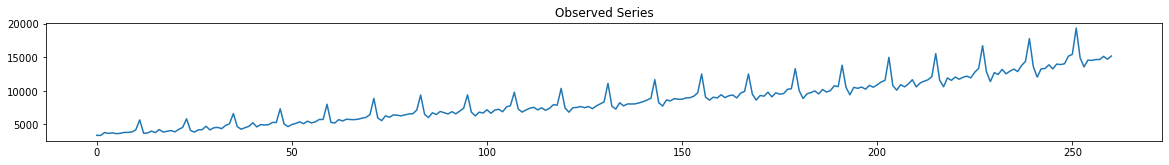

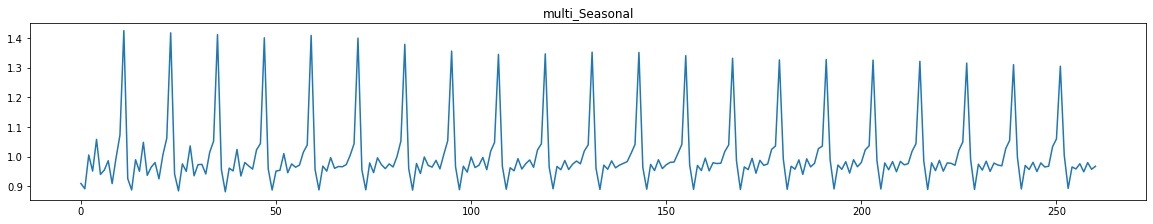

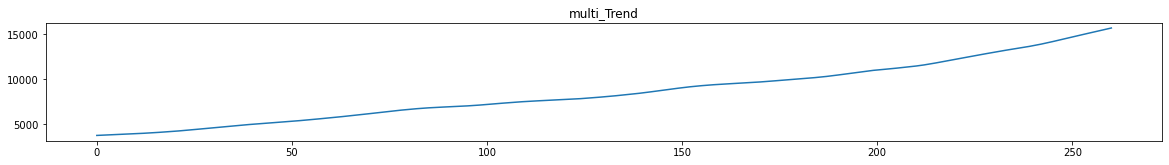

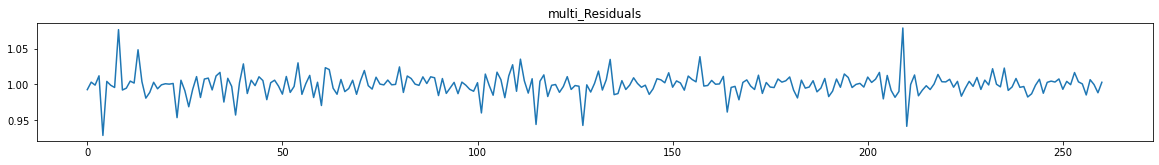

In [13]:
log_train = train.Turnover.apply(math.log)
log_decomp = STL(log_train, period=12, robust=True).fit()

#Plotting the observed series
plt.figure(figsize=(20,10))
plt.subplot(4,1,1)
plt.title("Observed Series")
train.Turnover.plot()
plt.show()  

#Now we plot separately
log_S,log_T,log_E = log_decomp.seasonal, log_decomp.trend, log_decomp.resid     
multi_S,multi_T,multi_E = log_S.apply(math.exp),log_T.apply(math.exp),log_E.apply(math.exp)    #transform back to non log values
plt.figure(figsize=(20,15))
plt.subplot(4,1,2)
plt.title("multi_Seasonal")
multi_S.plot()
plt.show()       

plt.figure(figsize=(20,10))
plt.subplot(4,1,3)
plt.title("multi_Trend")
multi_T.plot()
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(4,1,4)
plt.title("multi_Residuals")
multi_E.plot()
plt.show()

The seasonal plots have a constant interval spike, while the residuals now tend to fluctuate around the value of 1. Even though the peaks of the multiplicative seasonal part seem to have a slow decline(~0.1 decrease over 20 years), the troughs remain relatively similar. Plotting the lag plots for the seasonal series:

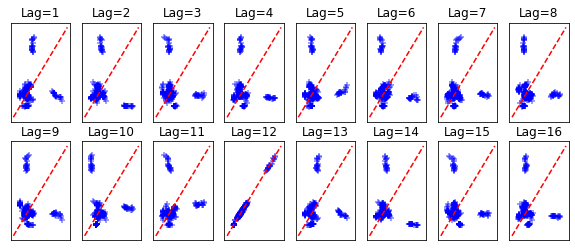

In [14]:
plt.figure(figsize=(10,4))
T_max = len(train) 
for lag in np.arange(1,17):
    plt.subplot(2,8,lag)      
    plt.scatter(multi_S[:(T_max)-lag], multi_S[lag:(T_max)], color="blue", marker="+", alpha=0.5)
    plt.plot([0.8,1.5], [0.8,1.5], "r--")  #add a red diagonal
    plt.title(f"Lag={lag}")
    plt.xticks([]) 
    plt.yticks([]) 

The lag of the multiplicative seasonal is also 12. We now investigate the residuals with the histogram and autocorrelation plots.

Mean of multi_residuals is 0.9995334672736541


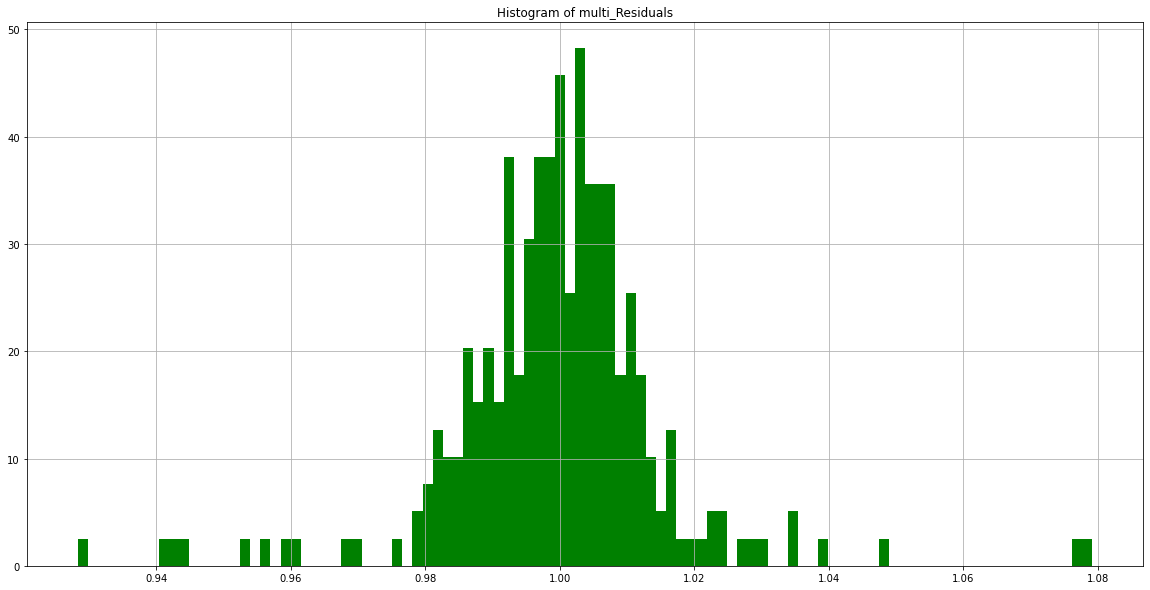

In [15]:
plt.figure(figsize=(20,10))
_ = plt.hist(multi_E, bins=100, density=True, color="green")
plt.grid(True)
plt.title("Histogram of multi_Residuals")  

print("Mean of multi_residuals is",np.mean(multi_E))

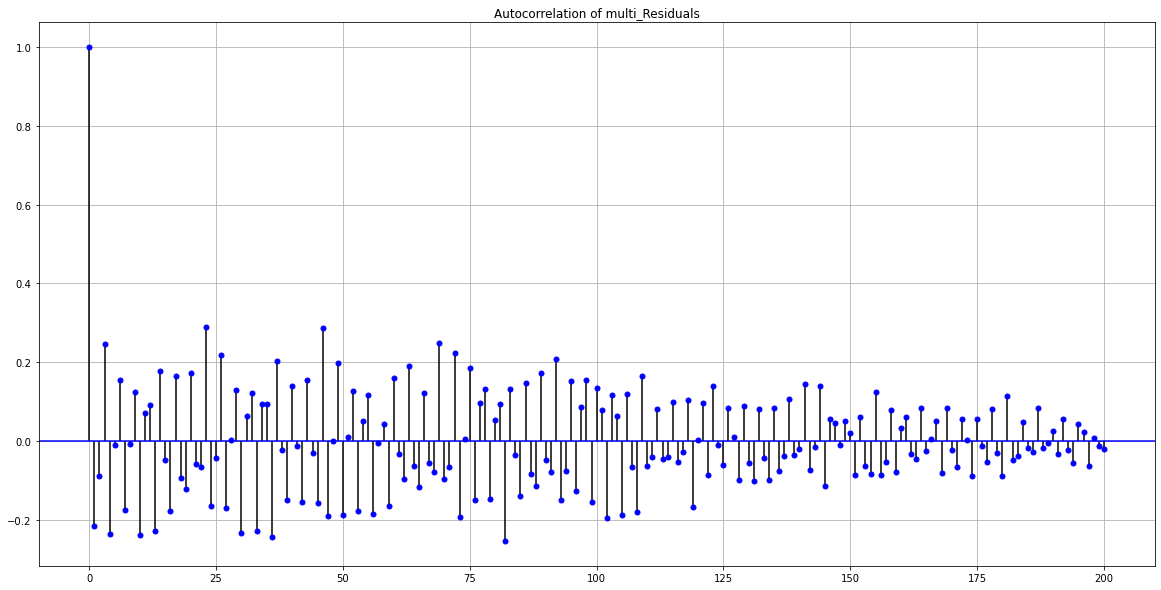

In [16]:
fig,ax = plt.subplots(figsize=(20,10)) 
multi_fig = tsaplots.plot_acf(multi_E, lags=200, alpha=None, title="Autocorrelation of multi_Residuals", color="blue",ax=ax)
plt.grid(True)

The histogram of the residuals looks similar to a normal distribution with mean 1, although it is very slightly skewed to the right. The autocorrelation plot also shows no significant correlation in the series. 

# Comparing Additive vs Multiplicative
Given that the multiplicative model has residuals that seem to follow a normal distribution more closely than the additive model, and the seasonal plots for the additive model has an increasing variance, we've concluded that the multiplicative model would be better for forecasting.

### We now try to use various methods taught before to see which method is the best for forecasting the turnover series.

# SES

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


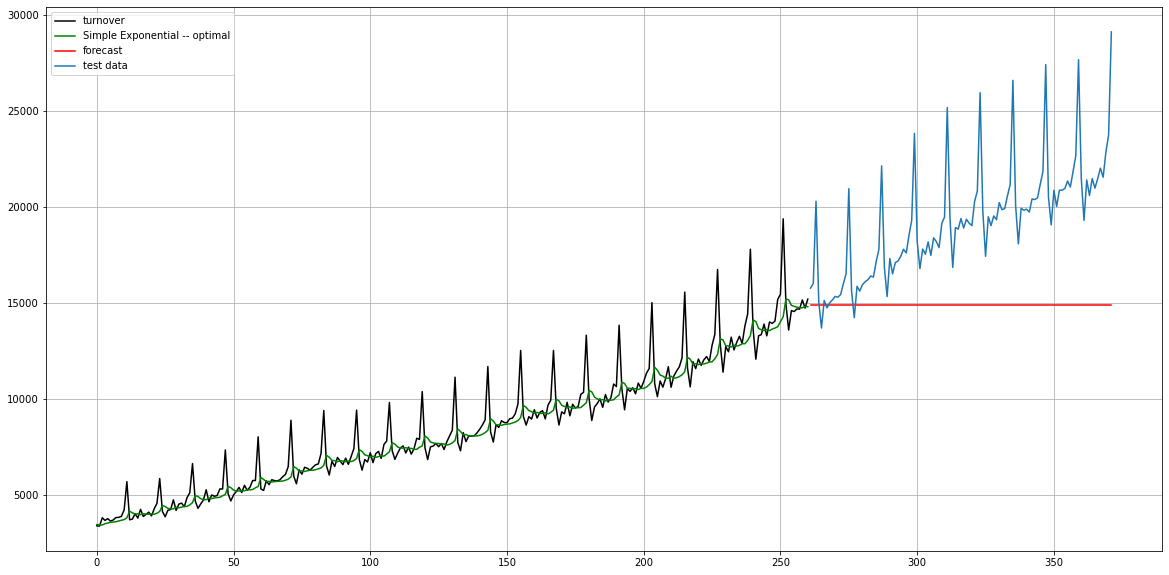

In [17]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
T_max = n_train
turnover = np.asarray(train.Turnover)

# auto-optimization that allows statmodels to auto find an optimized value for us
fit1 = SimpleExpSmoothing(turnover).fit(optimized=True)
plt.figure(figsize=(20,10))
plt.plot(turnover, "k-", label="turnover")
plt.plot( fit1.fittedvalues, "g-", label=rf"Simple Exponential -- optimal" ) 

forecast_length = n_test
forecast = fit1.forecast(forecast_length)
plt.plot(T_max + np.arange(forecast_length), forecast, "r-", label="forecast")
plt.grid(True)

plt.plot(test.Turnover,label="test data")
plt.legend()

In [18]:
print(np.sqrt(mean_squared_error(np.asarray(test.Turnover),forecast)))

5222.571047794711


# DES

In [19]:
#optimize alpha and beta for predicting
alpha_list = np.linspace(0, 1, 20)
beta_list = np.linspace(0, 1, 20)
phi = 0.95 #For damped additive. Usually restricted from 0.8 to 0.98
RMSE_array = np.zeros((len(alpha_list), len(beta_list)))

#Additive
for i,alpha in enumerate(alpha_list):
    for j,beta in enumerate(beta_list):
        fit = Holt(turnover).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
        forecast = fit.forecast(n_test)
        diff = test.Turnover - forecast
        RMSE = np.sqrt(np.mean(diff[-n_test:]**2))
        RMSE_array[i,j] = RMSE

A_alpha_index, A_beta_index = np.unravel_index(RMSE_array.argmin(), RMSE_array.shape)
A_alpha, A_beta = alpha_list[A_alpha_index] , beta_list[A_beta_index]

#Multiplicative
for i,alpha in enumerate(alpha_list):
    for j,beta in enumerate(beta_list):
        fit = Holt(turnover,exponential=True).fit(smoothing_level=alpha, smoothing_trend=beta, optimized=False)
        forecast = fit.forecast(n_test)
        diff = test.Turnover - forecast
        RMSE = np.sqrt(np.mean(diff[-n_test:]**2))
        RMSE_array[i,j] = RMSE

M_alpha_index, M_beta_index = np.unravel_index(RMSE_array.argmin(), RMSE_array.shape)
M_alpha, M_beta = alpha_list[M_alpha_index] , beta_list[M_beta_index]

#Damped Additive
for i,alpha in enumerate(alpha_list):
    for j,beta in enumerate(beta_list):
        fit = Holt(turnover,damped_trend=True).fit(smoothing_level=alpha, smoothing_trend=beta,damping_trend = phi,optimized=False)
        forecast = fit.forecast(n_test)
        diff = test.Turnover - forecast
        RMSE = np.sqrt(np.mean(diff[-n_test:]**2))
        RMSE_array[i,j] = RMSE

DA_alpha_index, DA_beta_index = np.unravel_index(RMSE_array.argmin(), RMSE_array.shape)
DA_alpha, DA_beta = alpha_list[DA_alpha_index] , beta_list[DA_beta_index]

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


In [20]:
print("Optimal alpha for additive is ",A_alpha)
print("Optimal beta for additive is ",A_beta)
print("Optimal alpha for multiplicative is ",M_alpha)
print("Optimal beta for multiplicative is ",M_beta)
print("Optimal alpha for damped additive is ",DA_alpha)
print("Optimal beta for damped additive is ",DA_beta)

Optimal alpha for additive is  0.10526315789473684
Optimal beta for additive is  0.10526315789473684
Optimal alpha for multiplicative is  0.05263157894736842
Optimal beta for multiplicative is  0.3157894736842105
Optimal alpha for damped additive is  0.2631578947368421
Optimal beta for damped additive is  0.8421052631578947


C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\results.py:169: FutureWarning: slope is deprecated and will be removed after 0.13
  warnings.warn(


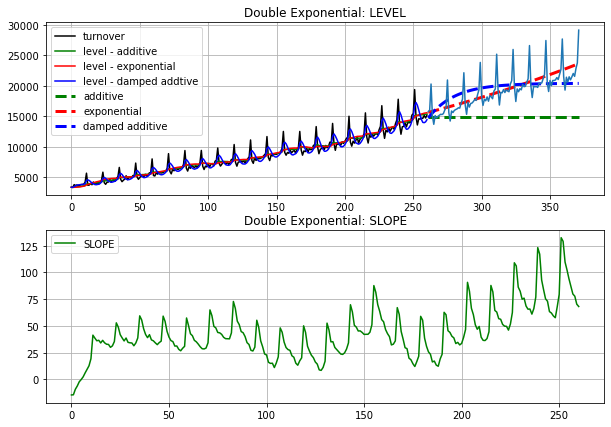

In [21]:
from statsmodels.tsa.holtwinters import Holt

# Additive model
fit = Holt(turnover).fit(smoothing_level = A_alpha, smoothing_trend=A_beta, optimized =False)
fcast1 = fit1.forecast(n_test)

# exponential model
fit2 = Holt(turnover, exponential = True).fit(smoothing_level = M_alpha, smoothing_trend = M_beta, optimized = False)
fcast2 = fit2.forecast(n_test)

# damped version of the Holt's additive model
fit3 = Holt(turnover, damped_trend=True).fit(smoothing_level =DA_alpha, smoothing_trend =DA_beta,damping_trend=phi,optimized=False)
fcast3 = fit3.forecast(n_test)

plt.figure(figsize=(10,7))
plt.subplot(2,1,1)
plt.plot(turnover[-T_max:], "k-", label="turnover")

plt.plot( fit.level[-T_max:], "g-", label="level - additive") 
plt.plot( fit2.level[-T_max:], "r-", label="level - exponential") 
plt.plot( fit3.level[-T_max:], "b-", label="level - damped addtive") 


plt.plot(T_max + np.arange(n_test), fcast1, "g--", label="additive", linewidth=3)
plt.plot(T_max + np.arange(n_test), fcast2, "r--", label="exponential", linewidth=3)
plt.plot(T_max + np.arange(n_test), fcast3, "b--", label="damped additive", linewidth=3)
plt.plot(test.Turnover)   

plt.grid(True)
plt.title(rf"Double Exponential: LEVEL")
plt.legend()

plt.subplot(2,1,2)
plt.plot( fit.slope[-T_max:], "g-", label="SLOPE" ) 
plt.title(rf"Double Exponential: SLOPE")
plt.grid(True)
plt.legend()

In [22]:
print("Additive: ", np.sqrt(mean_squared_error(np.asarray(test.Turnover),fcast1)))
print("Exponential: ",np.sqrt(mean_squared_error(np.asarray(test.Turnover),fcast2)))
print("Damped Additive: ",np.sqrt(mean_squared_error(np.asarray(test.Turnover),fcast3)))

Additive:  5222.571047794711
Exponential:  1962.3442476877267
Damped Additive:  2312.1616836536787


Multipicative(exponential) model worked the best as expected, followed by the damped additive model. Value of phi is usually restricted between 0.8 to 0.98, with value of 1 meaning that the damped additive model is closer to an additive model<sup>[1]</sup>. This means that short-run forecasts have a trend while long-run forecasts tend to a constant.

# TES

Here we try to find optimal alpha,beta and gamma for each of the four models:

1.   Additive
2.   Multiplicative
3.   Damped Additive
4.   Damped Multiplicative




In [23]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
#Additive
alpha_list = np.linspace(0,1,10)
beta_list = np.linspace(0,1,10)
gamma_list = 1-alpha_list     

TES_RMSE_array = np.zeros((len(alpha_list), len(beta_list),len(gamma_list)))
for i,alpha in enumerate(alpha_list):
    for j,beta in enumerate(beta_list):
        for g,gamma in enumerate(gamma_list):
          fit = ExponentialSmoothing(turnover, seasonal_periods = 12, trend = "add", seasonal = "add").fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
          forecast = fit.forecast(n_test)
          diff = test.Turnover - forecast
          RMSE = np.sqrt(np.mean(diff[-n_test:]**2))
          TES_RMSE_array[i,j,g] = RMSE

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to conve

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

In [24]:
AA_alpha_index, AA_beta_index, AA_gamma_index = np.unravel_index(TES_RMSE_array.argmin(), TES_RMSE_array.shape)
AA_alpha_opt,AA_beta_opt,AA_gamma_opt = alpha_list[AA_alpha_index], beta_list[AA_beta_index], gamma_list[AA_gamma_index]

In [25]:
#Multiplicative
alpha_list = np.linspace(0,1,10)
beta_list = np.linspace(0,1,10)
gamma_list = np.linspace(0,1,10)

TES_RMSE_array = np.zeros((len(alpha_list), len(beta_list),len(gamma_list)))
for i,alpha in enumerate(alpha_list):
    for j,beta in enumerate(beta_list):
        for g,gamma in enumerate(gamma_list):
          fit = ExponentialSmoothing(turnover, seasonal_periods = 12, trend = "add", seasonal = "mul").fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
          forecast = fit.forecast(n_test)
          diff = test.Turnover - forecast
          RMSE = np.sqrt(np.mean(diff[-n_test:]**2))
          TES_RMSE_array[i,j,g] = RMSE

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

In [26]:
AM_alpha_index, AM_beta_index, AM_gamma_index = np.unravel_index(TES_RMSE_array.argmin(), TES_RMSE_array.shape)
AM_alpha_opt,AM_beta_opt,AM_gamma_opt = alpha_list[AM_alpha_index], beta_list[AM_beta_index], gamma_list[AM_gamma_index]

In [27]:
#Damped Additive
alpha_list = np.linspace(0,1,10)
beta_list = np.linspace(0,1,10)
gamma_list = np.linspace(0,1,10)

TES_RMSE_array = np.zeros((len(alpha_list), len(beta_list),len(gamma_list)))
for i,alpha in enumerate(alpha_list):
    for j,beta in enumerate(beta_list):
        for g,gamma in enumerate(gamma_list):
          fit = ExponentialSmoothing(turnover, seasonal_periods = 12, trend = "add", seasonal = "add",damped_trend=True).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
          forecast = fit.forecast(n_test)
          diff = test.Turnover - forecast
          RMSE = np.sqrt(np.mean(diff[-n_test:]**2))
          TES_RMSE_array[i,j,g] = RMSE

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

In [28]:
ADM_alpha_index, ADM_beta_index, ADM_gamma_index = np.unravel_index(TES_RMSE_array.argmin(), TES_RMSE_array.shape)
ADM_alpha_opt,ADM_beta_opt,ADM_gamma_opt = alpha_list[ADM_alpha_index], beta_list[ADM_beta_index], gamma_list[ADM_gamma_index]

In [29]:
#Damped Multiplicative
alpha_list = np.linspace(0,1,10)
beta_list = np.linspace(0,1,10)
gamma_list = np.linspace(0,1,10)

TES_RMSE_array = np.zeros((len(alpha_list), len(beta_list),len(gamma_list)))
for i,alpha in enumerate(alpha_list):
    for j,beta in enumerate(beta_list):
        for g,gamma in enumerate(gamma_list):
          fit = ExponentialSmoothing(turnover, seasonal_periods = 12, trend = "add", seasonal = "mul",damped_trend=True).fit(smoothing_level=alpha, smoothing_trend=beta, smoothing_seasonal=gamma)
          forecast = fit.forecast(n_test)
          diff = test.Turnover - forecast
          RMSE = np.sqrt(np.mean(diff[-n_test:]**2))
          TES_RMSE_array[i,j,g] = RMSE

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:920: ConvergenceWarning: Optimization failed to converge

In [30]:
AMD_alpha_index, AMD_beta_index, AMD_gamma_index = np.unravel_index(TES_RMSE_array.argmin(), TES_RMSE_array.shape)
AMD_alpha_opt,AMD_beta_opt,AMD_gamma_opt = alpha_list[AMD_alpha_index], beta_list[AMD_beta_index], gamma_list[AMD_gamma_index]

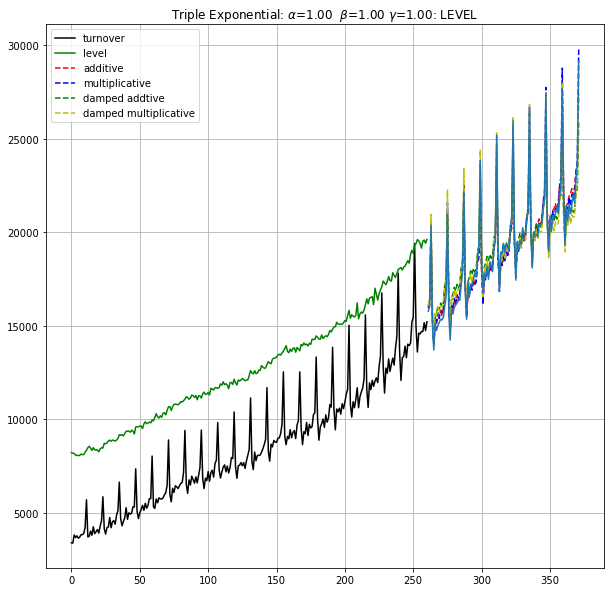

In [31]:

# Additive trend, addtive seasonal
fitone = ExponentialSmoothing(turnover, seasonal_periods = 12, trend = "add", seasonal = "add").fit(smoothing_level=AA_alpha_opt, smoothing_trend=AA_beta_opt, smoothing_seasonal=AA_gamma_opt)
forecast1 = fitone.forecast(forecast_length)

# Additive trend, multiplicative seasonal
fittwo = ExponentialSmoothing(turnover, seasonal_periods = 12, trend = "add", seasonal = "mul").fit(smoothing_level=AM_alpha_opt, smoothing_trend=AM_beta_opt, smoothing_seasonal=AM_gamma_opt)
forecast2 = fittwo.forecast(forecast_length)

# Additive damped trend, additive seasonal
fitthree = ExponentialSmoothing(turnover, seasonal_periods = 12, trend = "add", seasonal = "add", damped_trend = True).fit(smoothing_level=ADM_alpha_opt, smoothing_trend=ADM_beta_opt, smoothing_seasonal=ADM_gamma_opt)
forecast3 = fitthree.forecast(forecast_length)

# additive damped trend, multiplicative seasonal
fitfour = ExponentialSmoothing(turnover, seasonal_periods = 12, trend = "add", seasonal = "mul", damped_trend= True).fit(smoothing_level=AMD_alpha_opt, smoothing_trend=AMD_beta_opt, smoothing_seasonal=AMD_gamma_opt)
forecast4 = fitfour.forecast(forecast_length)


plt.figure(figsize=(10,10))
#plt.subplot(3,1,1)
plt.plot(turnover, "k-", label="turnover")
plt.plot( fitone.level, "g-", label="level") 
#plot separately
plt.plot(len(turnover) + np.arange(forecast_length), forecast1, "r--", label="additive", linewidth=1.5)
plt.plot(len(turnover) + np.arange(forecast_length), forecast2, "b--", label="multiplicative", linewidth=1.5)
plt.plot(len(turnover) + np.arange(forecast_length), forecast3, "g--", label="damped addtive", linewidth=1.5)
plt.plot(len(turnover) + np.arange(forecast_length), forecast4, "y--", label="damped multiplicative", linewidth=1.5)
plt.plot(test.Turnover)
plt.grid(True)
plt.title(rf"Triple Exponential: $\alpha$={alpha:2.2f}  $\beta$={beta:2.2f} $\gamma$={gamma:2.2f}: LEVEL")
plt.legend()

The forecast increased more slowly when damped option was used than when it wasn't used

In [32]:
print("Additive: ", np.sqrt(mean_squared_error(np.asarray(test.Turnover),forecast1)))
print("Multiplicative: ", np.sqrt(mean_squared_error(np.asarray(test.Turnover),forecast2)))
print("Damped Additive: ", np.sqrt(mean_squared_error(np.asarray(test.Turnover),forecast3)))
print("Damped Multiplicative: ", np.sqrt(mean_squared_error(np.asarray(test.Turnover),forecast4)))

Additive:  581.6554897441258
Multiplicative:  378.6071229170785
Damped Additive:  760.7902276475425
Damped Multiplicative:  541.3355395115091


For Holt-Winter's Additive method, gamma is usually restricted to 0$\le$ $\gamma$ $\le$ 1-$\alpha$. <sup>[2]</sup>

The multiplicative model had the smallest RMSE, followed by damped multiplicative. This is further evidence that the multiplicative model works the best in predicting.

Comparing RMSE alone between TES and DES methods, TES results are much better than DES. Thus, the seasonal component plays a huge role in forecasting turnover.

# Linear Regression
It is a linear approach to modeling the relationship between a scalar response and some explanatory variables. First, we constructed our naive model. It will be our baseline to compare our other approaches to. Our naive model will simply consist in predicting that the turnover in 12 months equals to the turnover at the current point.

In [33]:
# Naive Model
errors = dataset.Turnover.values[:-12] - dataset.Turnover.values[12:]

#let us compute the RMSE on the last 30% of data, test data
n_test = int(n_tot * 0.3)
RMSE_naive = np.sqrt(np.mean( errors[-n_test:]**2 ))
print(f"RMSE_naive={RMSE_naive: 2.2f}")

RMSE_naive= 853.82


Text(0.5, 1.0, 'RMSE = 853.82')

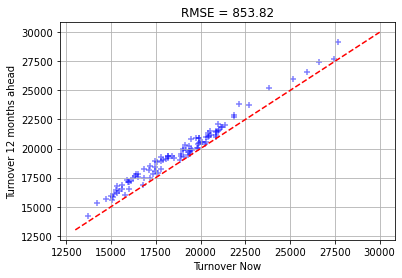

In [34]:
# test set
n_train = n_tot - n_test
plt.scatter(dataset.Turnover.values[n_train:-12], dataset.Turnover.values[n_train+12:], color="blue", marker="+", alpha=0.5)
plt.xlabel("Turnover Now")
plt.ylabel("Turnover 12 months ahead")
plt.grid(True)
plt.plot([13000,30000], [13000,30000], "r--")
plt.title(f"RMSE = {RMSE_naive:2.2f}")

In [35]:
from sklearn.linear_model import LinearRegression

Next, we tried to use the last N data to predict 12 months ahead. The last N data will be the current month data, as well as the n previous data. 

In [36]:
def linear_regression(N = 10):
    # let us build the matrix X for fitting a linear regression
    # the matrix X should contain all the covariates (ie. quantites used to make a prediction)
    T = 50
    # append all the covariates in a list
    covariates = []
    for k in range(N+1):
        covariates.append(dataset.Turnover[T-k:n_tot-12-k])
    # concatenate the list of vectors in a big matrix
    X_all = np.column_stack(covariates)
    # store the true values 
    y_all= dataset.Turnover[T+12:n_tot]

    #test/test set
    X_train = X_all[:n_train] # select first n_train 
    y_train = y_all[:n_train]
    X_test = X_all[n_train:]
    y_test = y_all[n_train:]
    # each row is the covariates
    return X_train, y_train, X_test, y_test
    

In [37]:
N = 13
X_train, y_train, X_test, y_test = linear_regression(N)
lin_reg = LinearRegression().fit(X_train, y_train)

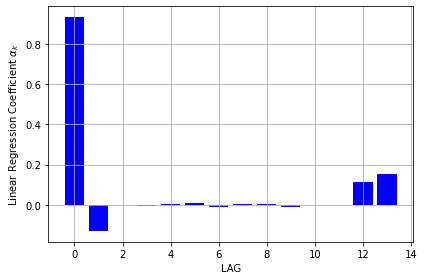

In [38]:
plt.bar(range(N+1), lin_reg.coef_, color="blue")
plt.grid(True)
plt.xlabel("LAG")
plt.ylabel(r"Linear Regression Coefficient $\alpha_k$")

plt.tight_layout()

In [39]:
lin_reg.coef_ #Small coefficients due to large values of inputs

array([ 9.33701906e-01, -1.30090902e-01, -9.47359422e-04, -3.09291768e-03,
        2.98496219e-03,  1.05372180e-02, -7.87855174e-03,  2.82441945e-03,
        3.06772119e-03, -1.25712534e-02, -7.21648012e-04,  1.86239353e-03,
        1.13385731e-01,  1.53849073e-01])

In [40]:
y_test_pred = lin_reg.predict(X_test)

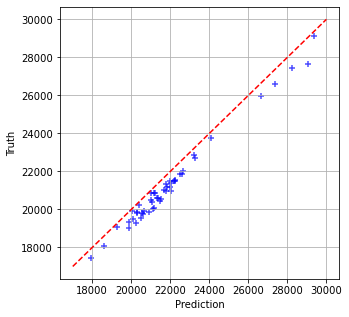

In [41]:
plt.figure(figsize=(5,5))
plt.plot([17000,30000], [17000,30000], "r--")   #A diagonal line
plt.scatter(y_test_pred, y_test, marker="+", color="blue", alpha=0.7)
plt.xlabel("Prediction")
plt.ylabel("Truth")
plt.grid(True)

Predicted data always falls slightly below the real value.
As we have observed that using 10 previous data points may not be sufficient, we check if it is worth to add more data (or even lesser data) in the linear model to predict. 

In [42]:
days_list = np.arange(1,30)    
RMSE_list = []
for N in days_list:
    X_train, y_train, X_test, y_test = linear_regression(N)
    lin_reg = LinearRegression().fit(X_train, y_train)
    y_test_pred = lin_reg.predict(X_test)
    errors = y_test - y_test_pred
    RMSE = np.sqrt(np.mean( errors**2 ))
    RMSE_list.append(RMSE)

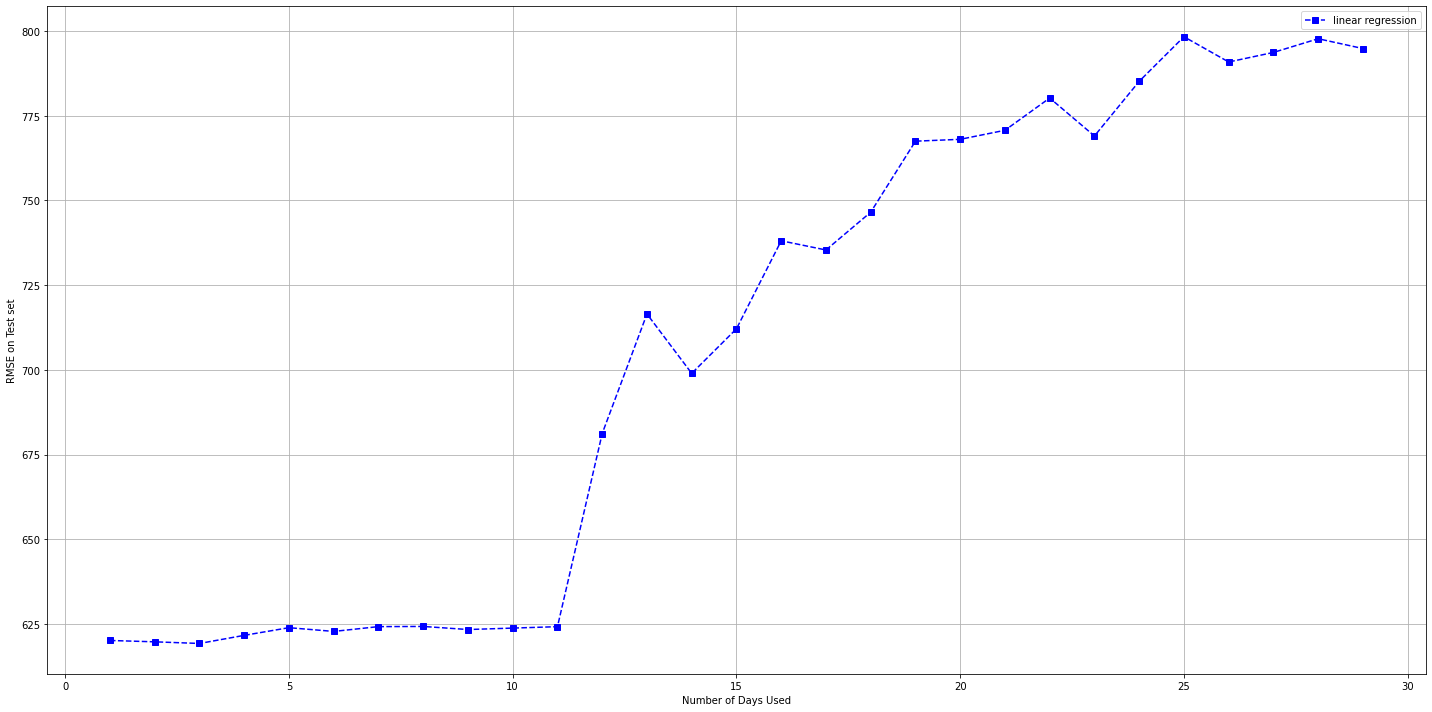

In [43]:
plt.figure(figsize=(20,10))
plt.plot(days_list, RMSE_list, "b--s", label="linear regression")
plt.legend()
plt.grid(True)
plt.xlabel("Number of Days Used")
plt.ylabel("RMSE on Test set")

plt.tight_layout()

As observed in the figure above, N = 3 yields that lowest RMSE of 619.23. This value is lower than the RMSE of the naive model. Since we observed that there is a seasonal effect in the data, we ulitise this information by incorporating the data of the last year around the same month to further improve on this model. 

In [44]:
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics import tsaplots
#import statsmodels

In [45]:
# two sided moving average
smoothing_filter = np.ones(25)/25.
temp_MA = statsmodels.tsa.filters.filtertools.convolution_filter(dataset.Turnover.values, filt=smoothing_filter, nsides = 2)

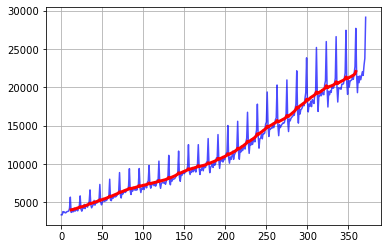

In [46]:
plt.plot(dataset.Turnover.values, "b-", alpha=0.7)
plt.plot(temp_MA, "r-", lw=3)
plt.grid(True)

In [47]:
def linear_regression_with_MA(N = 10):
    T = 50

    # append all the covariates in a list
    n_tot = len(dataset)
    n_test = int(n_tot * 0.3)     #30% of data is the test set
    n_train = n_tot - n_test
    covariates = []
    for k in range(N+1):
        covariates.append(dataset.Turnover[T-k:n_tot-12-k])
    # also use the average the same day but previous year
    covariates.append(temp_MA[T-12:n_tot-12-12])
    # concatenate the list of vectors in a big matrix
    X_all = np.column_stack(covariates)
    # store the true values (i.e 12 months ahead) 
    y_all= dataset.Turnover[T+12:n_tot]

    #test/test set
    X_train = X_all[:n_train]
    y_train = y_all[:n_train]
    X_test = X_all[n_train:]
    y_test = y_all[n_train:]

    return X_train, y_train, X_test, y_test

In [48]:
days_list = np.arange(1,30)
RMSE_ma_list = []
for N in days_list:
    X_train, y_train, X_test, y_test = linear_regression_with_MA(N)
    lin_reg = LinearRegression().fit(X_train, y_train)
    y_test_pred = lin_reg.predict(X_test)
    errors = y_test - y_test_pred
    RMSE_ma = np.sqrt(np.mean( errors**2 ))
    RMSE_ma_list.append(RMSE_ma)

Text(0, 0.5, 'RMSE on Test set')

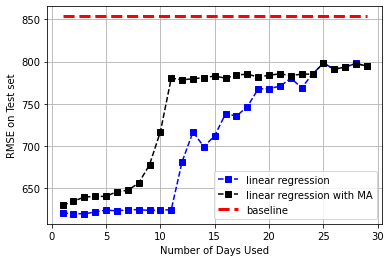

In [49]:
plt.plot(days_list, RMSE_list, "b--s", label="linear regression")
plt.plot(days_list, RMSE_ma_list, "k--s", label="linear regression with MA")

plt.plot(days_list, [RMSE_naive for _ in days_list], "r--", lw=3, label="baseline")
plt.legend()

plt.grid(True)
plt.xlabel("Number of Days Used")
plt.ylabel("RMSE on Test set")

However, we observed that using the average of the previous year at the same period doesn't help our model. We also tried Feature engineering by using Exponential Smoothing covariates.

In [50]:
from statsmodels.tsa.api import SimpleExpSmoothing

C:\Users\test\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:427: FutureWarning: After 0.13 initialization must be handled at model creation
  warnings.warn(


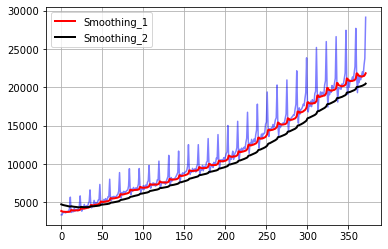

In [51]:
plt.plot(dataset.Turnover, "b-", alpha=0.5)
SES_1 = SimpleExpSmoothing(dataset.Turnover.values).fit(smoothing_level=0.1,optimized=True).fittedvalues
SES_2 = SimpleExpSmoothing(dataset.Turnover.values).fit(smoothing_level=0.03,optimized=True).fittedvalues

plt.plot(SES_1, "r-", lw=2, label="Smoothing_1")
plt.plot(SES_2, "k-", lw=2, label="Smoothing_2")

plt.grid(True)
plt.legend()

In [52]:
smoothing_filter = np.ones(25)/25
MA = statsmodels.tsa.filters.filtertools.convolution_filter(dataset.Turnover.values, filt=smoothing_filter, nsides = 2)

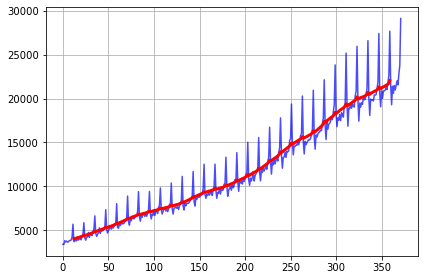

In [53]:
plt.plot(dataset.Turnover, "b-", alpha=0.7)
plt.plot(MA, "r-", lw=3)
plt.grid(True)
plt.tight_layout()

In [54]:
def linear_regression_with_MA_SES(N = 10):
    T = 50
    # append all the covariates in a list
    covariates = []
    for k in range(N+1):
        covariates.append(dataset.Turnover[T-k:n_tot-12-k])
    # also use the average the same day but previous year
    covariates.append(MA[T-12:n_tot-12-12])
    covariates.append(SES_1[T-12:n_tot-12-12])
    covariates.append(SES_2[T-12:n_tot-12-12])

    # concatenate the list of vectors in a big matrix
    X_all = np.column_stack(covariates)
    # store the true values (i.e 12 months ahead) 
    y_all= dataset.Turnover[T+12:n_tot]

    #test/test set
    X_train = X_all[:n_train]
    y_train = y_all[:n_train]
    X_test = X_all[n_train:]
    y_test = y_all[n_train:]

    return X_train, y_train, X_test, y_test

In [55]:
X_train, y_train, X_test, y_test = linear_regression_with_MA_SES(N)
lin_reg_ma_ses = LinearRegression().fit(X_train, y_train)
y_test_pred = lin_reg_ma_ses.predict(X_test)
errors = y_test - y_test_pred
RMSE_ma_ses = np.sqrt(np.mean( errors**2 ))

In [56]:
# let us check if it is worth adding more data points
days_list =  np.arange(1,30)
RMSE_ma_ses_list = []
for N in days_list:
    X_train, y_train, X_test, y_test = linear_regression_with_MA_SES(N)
    lin_reg_ma_ses = LinearRegression().fit(X_train, y_train)
    y_test_pred = lin_reg_ma_ses.predict(X_test)
    errors = y_test - y_test_pred
    RMSE_ma_ses = np.sqrt(np.mean( errors**2 ))
    RMSE_ma_ses_list.append(RMSE_ma_ses)

Text(0, 0.5, 'RMSE on Test set')

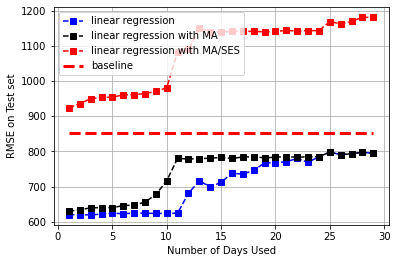

In [57]:
plt.plot(days_list, RMSE_list, "b--s", label="linear regression")
plt.plot(days_list, RMSE_ma_list, "k--s", label="linear regression with MA")
plt.plot(days_list, RMSE_ma_ses_list, "r--s", label="linear regression with MA/SES")


plt.plot(days_list, [RMSE_naive for _ in days_list], "r--", lw=3, label="baseline")

plt.legend()

plt.grid(True)
plt.xlabel("Number of Days Used")
plt.ylabel("RMSE on Test set")

Note that the linear regression performed the best. Although it has performed fairly well, this model is still very limited as it is limited to linear relationships

# Comparing of Models

RMSE of:
- SES(Additive):  5215.852295619653
- DES(Additive):  5215.852295619653
- DES(Multiplicative):  1962.3442476877267
- DES(Damped Additive):  2312.1616836536787
- TES(Additive):  581.6639511393594
- TES(Multiplicative):  366.2726548495789
- TES(Damped Additive):  750.2524118570235
- TES(Damped Multiplicative):  531.9117430164614
- Naive Linear Regression: 853.8190546644574

For Linear Regression: 
- Naive Linear Regression: 853.8190546644574
- Linear Regression with last N data and the average of last year around the same month (MA): 629.34835266608
- Linear Regression with last N data and the average of last year around the same month (MA) and exponential smoothing: 924.5136961333342
- Linear Regression with last N data: 619.23





From the results, we can conclude that using a multiplicative model with TES would yield the greatest results out of all methods, especially for forecasting turnover much further into the future. 

For linear regression, the results are very promising, but is limited to the preceding months(dependent on number of past data points) of the month we wish to predict, hence we cannot use linear regression to predict too far ahead. For predictions that are closer to the latest data point available, linear regression would be preferred. 

## References
1. Forecasting: Principles&nbsp;and&nbsp;Practice. (n.d.). Retrieved November 13, 2020, from https://otexts.com/fpp2/holt-winters.html

2. Forecasting: Principles&nbsp;and&nbsp;Practice. (n.d.). Retrieved November 13, 2020, from https://otexts.com/fpp2/holt.html